100%|████████████████████████████████████████████| 9.91M/9.91M [00:40<00:00, 247kB/s]
100%|████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 150kB/s]
100%|███████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.35MB/s]
100%|████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 304kB/s]


Epoch [1/5] Batch [0/938] Loss: 2.3287
Epoch [1/5] Batch [100/938] Loss: 0.4591
Epoch [1/5] Batch [200/938] Loss: 0.2475
Epoch [1/5] Batch [300/938] Loss: 0.2322
Epoch [1/5] Batch [400/938] Loss: 0.1345
Epoch [1/5] Batch [500/938] Loss: 0.1941
Epoch [1/5] Batch [600/938] Loss: 0.1400
Epoch [1/5] Batch [700/938] Loss: 0.3160
Epoch [1/5] Batch [800/938] Loss: 0.1327
Epoch [1/5] Batch [900/938] Loss: 0.1300
Epoch [2/5] Batch [0/938] Loss: 0.0969
Epoch [2/5] Batch [100/938] Loss: 0.0803
Epoch [2/5] Batch [200/938] Loss: 0.0674
Epoch [2/5] Batch [300/938] Loss: 0.1034
Epoch [2/5] Batch [400/938] Loss: 0.1803
Epoch [2/5] Batch [500/938] Loss: 0.0535
Epoch [2/5] Batch [600/938] Loss: 0.0118
Epoch [2/5] Batch [700/938] Loss: 0.0370
Epoch [2/5] Batch [800/938] Loss: 0.1111
Epoch [2/5] Batch [900/938] Loss: 0.0661
Epoch [3/5] Batch [0/938] Loss: 0.0742
Epoch [3/5] Batch [100/938] Loss: 0.0288
Epoch [3/5] Batch [200/938] Loss: 0.1191
Epoch [3/5] Batch [300/938] Loss: 0.1607
Epoch [3/5] Batch [400

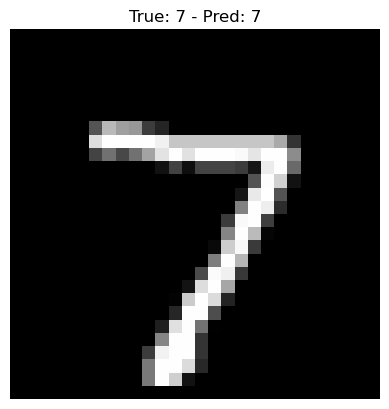

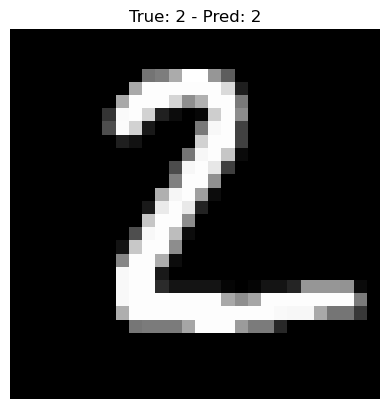

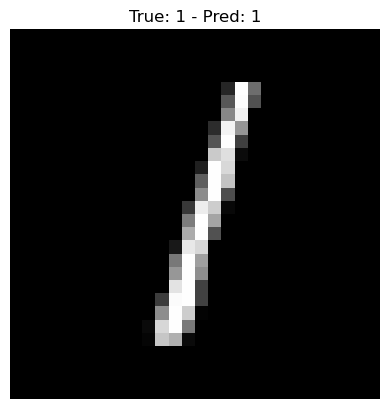

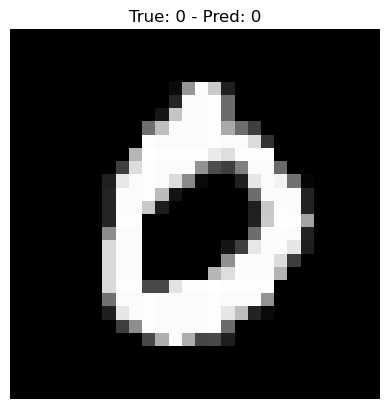

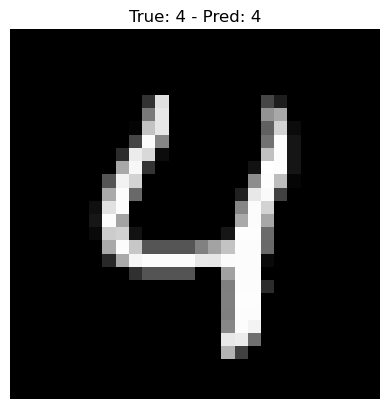

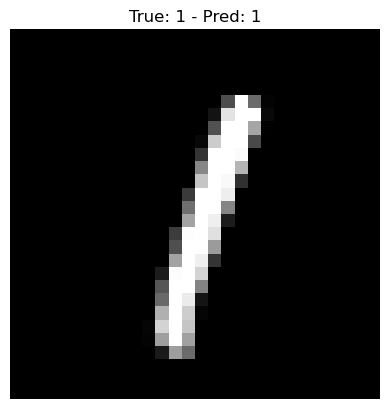

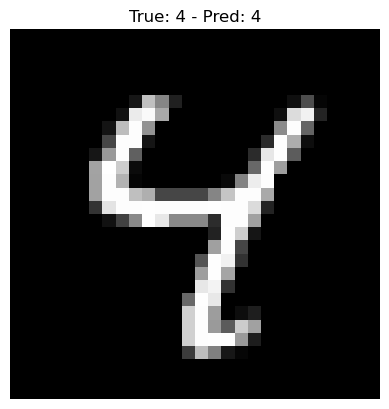

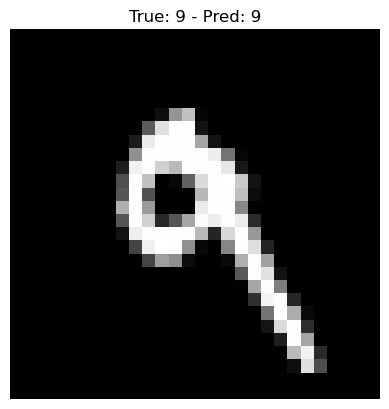

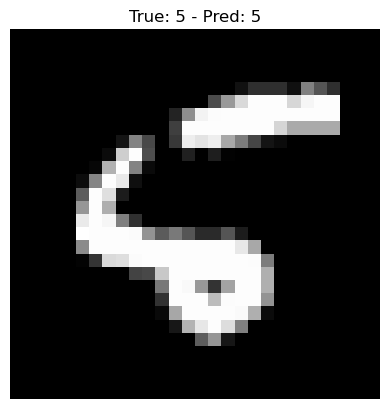

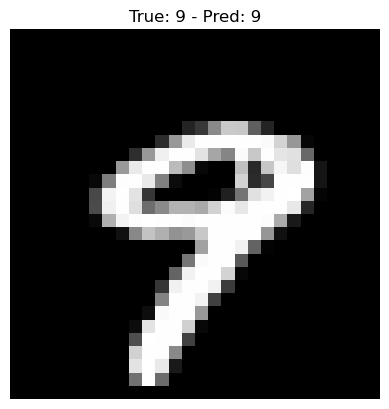

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# device 설정 (GPU 사용 가능할 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리: 텐서 변환 및 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST 데이터 다운로드 (학습/테스트 데이터셋)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader 생성
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# 간단한 신경망 모델 정의 (완전연결층)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.fc(x)

model = SimpleNN().to(device)

# 손실함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')

# 테스트 데이터셋에 대한 평가
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()  # 배치별 손실 누적
        pred = output.argmax(dim=1, keepdim=True)  # 예측 결과: 가장 높은 확률의 클래스 선택
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

# 테스트 데이터셋 일부를 시각화하여 예측 결과 확인
def imshow(img, title):
    # 이미지 텐서를 numpy 배열로 변환 후 시각화 (채널 차원 제거)
    img = img.cpu().squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 테스트 데이터에서 첫 배치를 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

# 첫 10개의 이미지와 예측 결과 시각화
for i in range(10):
    title = f"True: {labels[i].item()} - Pred: {preds[i].item()}"
    imshow(images[i], title)
